<a href="https://colab.research.google.com/github/axiao23/BryanRanger--Enhancing-Newborn-Health-Assessment/blob/main/UNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deep Learning UNet Model to Predict Body Composition from Infant Ultrasound Images**

The following notebook is a detailed account of the methods and model architecture used to perform a regression task from a UNet model. The model is trained on clinical Ultrasound data which has been pre-processed and manipulated to fit the parameters of the deep learning model. The layers of the model are clearly detailed below, along with the corresponding training. A 5-fold cross validation technique is implemented to increase the robustness of the results given the dataset size. Furthermore, statistical analysis functions are defined and used to quantify results.

The notebook contains methods utilized in the paper titled: Enhancing Newborn Health Assessment: Ultrasound-based Body Composition Prediction Using Deep Learning Techniques in the journal Ultrasound in Medicine & Biology.

Further inquiries about the project can be sent to rangerlabbc@gmail.com

## The following cell defines all nessecary packages used to run the code.

Additionally, Google Drive is mounted to the notebook. The Drive contains ultrasound images of body regions corresponding to infants.  

In [ ]:
## Importing all nessecary packages and tools
import os
import cv2
import math
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from datetime import date
from skimage import io, color
from google.colab import drive
from torchvision import models
import skimage.morphology as mo
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageFilter
from scipy.ndimage import median_filter
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
from torch.utils.data  import Dataset, DataLoader
from sklearn.model_selection import train_test_split


from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image
# from utils import *
# import timm
# from timm.models.layers import DropPath, to_2tuple, trunc_normal_
# import types

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Necessary Pre-Processing

The following four cells mount the proper folders and sets up the data and the patients with matching body composition metric. To do this, there must be another file, specifically a csv file which contains a nominal list of all patients, body composition metrics which can then be mapped to folders of corresponding patient_id.

The ultrasound data is not publically available.






**Step 1: Count total number of images across all patients in the dataset folder**


In [ ]:
# Root directory containing all patient subfolders with cropped ultrasound images
root_dir = '/content/gdrive/MyDrive/Ultrasound Files- Minnesota + Boston Collaboration/cropped_images_bluethingremoved'
# List of patient subdirectories (each folder corresponds to one patient)
patients = os.listdir(root_dir)
# Count total number of image files across all patients
total = 0
for patient in patients:
  total += len(os.listdir(os.path.join(root_dir, patient)))
print(total) # should be 721

721



**Step 2: Load patient metadata from CSV and compare with folder structure**

Here, we read csv data into a dataframe and collect all patient 'Study ID'. We print out number of patients in csv file and in folder. The number of patients in folder determine our dataset size for training and testing.


In [ ]:
# Read metadata file containing patient IDs and body composition measurements
df = pd.read_csv('/content/gdrive/MyDrive/Ultrasound Files- Minnesota + Boston Collaboration/Data_11.5.23_modified.csv')
# Extract Study IDs from the CSV
patients = df['Study_ID']
# Get list of patient folders in the cropped_images directory
folders = os.listdir('/content/gdrive/MyDrive/Ultrasound Files- Minnesota + Boston Collaboration/cropped_images') #cropped_images_bluethingremoved
#Confirm matching number of patients
print('Number of patients in csv file: ', len(patients))
print('Number of patients in folder: ', len(folders))

Number of patients in csv file:  65
Number of patients in folder:  65


**Step 3: Build dictionaries for labels (FM, FFM, Weight, Length)**

Here, create two dictionary, using 'Study ID' as key, and ['FM', 'FFM', 'Weight_visit', 'Length_visit'] as value. Create the test dictionary from the training dictionary.





In [ ]:
# Create dictionary mapping Study_ID -> [FM, FFM, Weight_visit, Length_visit]
labels_dict = df.set_index('Study_ID')[['FM', 'FFM', 'Weight_visit', 'Length_visit']].apply(list, axis=1).to_dict()
# Define which patient IDs will be reserved for testing
test_data = [17042418, 9021218, 35080318, 58041919, 65050619, 57032919, 50102518]#, , , 57032919, 67062119, 60042419, 44091318]
# Create test dictionary from training dictionary
test_labels_dict = {k: labels_dict[k] for k in test_data if k in labels_dict}
# Remove test patients from training dictionary
for i in test_data:
  del labels_dict[i]
PATIENTS = [str(num) for num in test_data]

print(len(labels_dict))
print(len(test_labels_dict))

58
7


**Step 4: The cell below checks that there's no missing images in the folder left.**

In [ ]:
# Assuming each patient in the dictionaries has a list of image paths as one of the values.
# If the dictionary structure is different, this code will need adjustment.

total_train_images = 0
for patient_id, data in labels_dict.items():

    patient_path = os.path.join(root_dir, str(patient_id))
    if os.path.exists(patient_path):
        total_train_images += len(os.listdir(patient_path))
    else:
        print(f"Warning: Directory not found for patient {patient_id}")


total_test_images = 0
for patient_id, data in test_labels_dict.items():
    patient_path = os.path.join(root_dir, str(patient_id))
    if os.path.exists(patient_path):
        total_test_images += len(os.listdir(patient_path))
    else:
        print(f"Warning: Directory not found for test patient {patient_id}")

print("Total number of images for training dataset:", total_train_images)
print("Total number of images for test dataset:", total_test_images)

Total number of images for training dataset: 581
Total number of images for test dataset: 75


##In the next following section, we define the universal data-loading, training and statistics functions.

These functions are used primarily to split and process the ultrasound images into training and testing groups. The PatientDataset function and TestPatientDataset function are both used to process ultrasound images so that they are able to be thread into the deep learning models. Some modifications of the models are done in subsequent blocks due to shape differences in the first layer of the deep learning models.

The training function is also defined in this section. In this function, the loss function is defined, along with the optimizer. The data is parsed and assigned to be trained by a specific model which is indicated in the training function. The training function utilizes a data-loader, which then keeps track of the training and validation losses as the training begins.

Loss functions, and metric functions (including MAPE, MSE, RSME and MAE) are defined and instantiated in the sequence below too. These are used to quantify the performance of our models.

In [ ]:
class PatientDataset(Dataset):
  """
    PyTorch Dataset for loading ultrasound images and associated patient labels.

    This dataset handles:
    - Selecting patient folders from the root directory
    - Excluding test patients
    - Loading images per region (Biceps, Abdomen, Quadriceps)
    - Applying optional preprocessing (thresholding, speckle reduction, denoising, cropping)
    - Returning the requested target output (FM or FFM) along with weight and length

    Args:
        transform (callable, optional):
            Image transform/augmentation function applied after loading.
        augmented_dataset (bool):
            If True, apply augmentation to the *entire dataset* instead of per-image.
        augment (int):
            Level of augmentation:
                0 = none,
                5 = augment each image 4x plus original,
                8 or 15 = stronger augmentation settings.
        threshold (bool):
            If True, remove pixels under a certain threshold (noise reduction).
        speckle (bool):
            If True, apply median filter for speckle noise reduction.
        despeckle (bool):
            If True, apply fast Non-Local Means denoising.
        region_combination (str):
            Which regions to include:
                "B" = Biceps,
                "A" = Abdomen,
                "Q" = Quadriceps,
                "BA", "BQ", "AQ", "BAQ" = multiple regions.
        number_of_image (int):
            Number of images to load per region (1, 2, or 3).
        crop (list of float):
            Fraction of each image to keep for [Abdomen, Biceps, Quadriceps].
            Example: [0.8, 1, 0.5] keeps 80% of Abdomen, full Biceps, 50% Quadriceps.
        output (str):
            Target label to predict:
                "FM" = Fat Mass,
                "FFM" = Fat-Free Mass.

    Returns:
        images (list[torch.Tensor]): List of preprocessed ultrasound images for the patient.
        label (float): Target label (FM or FFM).
        weight (float): Patient's body weight from metadata.
        length (float): Patient's body length from metadata.
    """
    def __init__(self, transform = None,
                 augmented_dataset = False, # Determine if we want to augment entire dataset instead of augmenting individual image
                 augment = 0, # this can be 0 (no augmentation), 5 (augment by 4 times plus original image), 8 and 15
                 threshold = False, # Remove all pixels under a certain threshold
                 speckle = False, # Apply median filter
                 despeckle = False, # Apply fast NL mean denoising
                 region_combination = "BAQ", # this can be B, A, Q, BA, BQ, AQ, BAQ
                 number_of_image = 2, # this can be 1, 2, 3, number of image for each region
                 crop = [1, 1, 1], # Only keep the x percentage of the image in the order of Abdomen, Biceps, and Quadriceps
                 output = "FM" # this can be FM or FFM, depending on which we want to predict
                 ):
        self.root_dir = '/content/gdrive/MyDrive/Ultrasound Files- Minnesota + Boston Collaboration/cropped_images' #cropped_images_bluethingremoved
        self.patients = os.listdir(self.root_dir)
        for data in test_data:
          self.patients.remove(str(data))
        self.transform = transform
        self.augment = augment
        self.threshold = threshold
        self.speckle = speckle
        self.augmented_dataset = augmented_dataset
        self.despeckle = despeckle
        self.region_combination = region_combination
        self.number_of_image = number_of_image
        self.crop = crop
        self.output = output

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_path = os.path.join(self.root_dir, patient_id)
        images = self.load_patient_data(patient_path)
        if len(images) == 0:
          raise RuntimeError(f"No images loaded for patient {patient_id}")
        label_FM = labels_dict[int(patient_id)][0]
        label_FFM = labels_dict[int(patient_id)][1]
        if self.output == "FM":
          return images, label_FM, labels_dict[int(patient_id)][2], labels_dict[int(patient_id)][3]
        if self.output == "FFM":
          return images, label_FFM, labels_dict[int(patient_id)][2], labels_dict[int(patient_id)][3]

    def preprocess(self, img_path, MF_size, images, threshold, h, templateWindowSize, searchWindowSize, crop):
        image = Image.open(img_path)
        width, height = image.size
        crop_rectangle = (0, 0, width, round(height*crop))
        image = image.crop(crop_rectangle)
        if self.speckle:
          image = image.filter(ImageFilter.MedianFilter(size=MF_size))
        if self.threshold:
          image = torch.where(image < threshold/255, torch.tensor(0.0), image)
        if self.despeckle:
          image_np = np.array(image)
          despeckled_image = cv2.fastNlMeansDenoisingColored(image_np, None, h=10, templateWindowSize=7, searchWindowSize=21)
          image = Image.fromarray(despeckled_image)
        if not self.augmented_dataset:
          image = self.transform(image)
        images.append(image)

        ## Augmentation
        # Augment by 5 times
        if self.augment >= 5:
          imx = image
          imx = TF.hflip(imx)
          images.append(imx)
          imx = TF.vflip(imx)
          images.append(imx)
          angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          imx = TF.rotate(imx, angle)
          images.append(imx)
        # Augment by 8 times
        if self.augment >= 8:
          imx = TF.vflip(imx)
          images.append(imx)
          angle = random.choice([15])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([45])
          imx = TF.rotate(imx, angle)
          images.append(imx)
        # Augment by 15 times
        if self.augment >= 15: #
          imx = image
          angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          imx = image
          angle = random.choice([-90])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          imx = image
          angle = random.choice([-60])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([-45])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([-15])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([30])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([60])
          imx = TF.rotate(imx, angle)
          images.append(imx)
        return images

    def load_patient_data(self, patient_path):
        images = []
        threshold = 100
        AB = 0
        BICEP = 0
        QUAD = 0
        MF_size = 5
        h = 10
        templateWindowSize = 7
        searchWindowSize = 21
        for img_file in os.listdir(patient_path):
          # Process Abdomen images
          if 'A' in self.region_combination and '_A' in img_file and AB < self.number_of_image:
              img_path = os.path.join(patient_path, img_file)
              images = self.preprocess(img_path, MF_size, images, threshold, h, templateWindowSize, searchWindowSize, self.crop[0])
              AB += 1
          # Process Bicep images
          elif 'B' in self.region_combination and '_B' in img_file and BICEP < self.number_of_image:
              img_path = os.path.join(patient_path, img_file)
              images = self.preprocess(img_path, MF_size, images, threshold, h, templateWindowSize, searchWindowSize, self.crop[1])
              BICEP += 1
          # Process Quad images
          elif 'Q' in self.region_combination and '_Q' in img_file and QUAD < self.number_of_image:
              img_path = os.path.join(patient_path, img_file)
              images = self.preprocess(img_path, MF_size, images, threshold, h, templateWindowSize, searchWindowSize, self.crop[2])
              QUAD += 1
        return images

In [ ]:
def im_converterX(tensor):
  """
    Convert a PyTorch tensor into a NumPy image (H x W x C) for visualization.

    Steps:
        1. Move tensor to CPU (if on GPU).
        2. Detach from computation graph (so gradients are not tracked).
        3. Convert to NumPy array.
        4. Rearrange dimensions from (C, H, W) -> (H, W, C).
        5. Scale pixel values into [0, 1] range and clip.

    Args:
        tensor (torch.Tensor):
            Image tensor in CHW format, typically with values normalized
            to [0, 1] or [-1, 1].

    Returns:
        numpy.ndarray:
            Image in HWC format with pixel values clipped between 0 and 1.
    """
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((1, 1, 1))
  image = image.clip(0, 1)
  return image

In [ ]:
class MAPELoss(nn.Module):
  """
    Mean Absolute Percentage Error (MAPE) Loss for regression tasks.

    This loss is useful when the scale of the target values varies a lot,
    because it expresses error as a percentage of the true value.

    Formula:
        MAPE = mean( |(target - pred) / (target + epsilon)| ) * 100

    Args:
        epsilon (float, optional): Small constant to avoid division by zero
                                   when target values are close to 0. Default = 1e-7.

    Forward Args:
        pred (torch.Tensor): Predicted values from the model.
        target (torch.Tensor): Ground truth values.

    Returns:
        torch.Tensor: Scalar tensor containing the MAPE loss (percentage).
    """
    def __init__(self, epsilon=1e-7):
        super(MAPELoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        return torch.mean(torch.abs((target - pred) / (target + self.epsilon))) * 100

In [ ]:
class CustomLoss(nn.Module):
  """
    Custom regression loss that combines Mean Squared Error (MSE) and
    Mean Absolute Error (L1/MAE) using weighted averaging.

    Motivation:
        - MSE penalizes large errors more strongly (sensitive to outliers).
        - L1 (MAE) is more robust to outliers but less sensitive to small differences.
        - Combining both gives a balanced trade-off.

    Formula:
        total_loss = weight_mse * MSE(input, target)
                   + weight_l1  * L1(input, target)

    Args:
        weight_mse (float): Weight for the MSE component. Default = 0.6
        weight_l1 (float): Weight for the L1 component.  Default = 0.4

    Forward Args:
        input (torch.Tensor): Predicted values from the model.
        target (torch.Tensor): Ground truth values.

    Returns:
        torch.Tensor: Scalar tensor containing the weighted loss.
    """

    def __init__(self, weight_mse=0.6, weight_l1=0.4):
        super(CustomLoss, self).__init__()
        self.weight_mse = weight_mse
        self.weight_l1 = weight_l1
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

    def forward(self, input, target):
        mse_loss = self.mse_loss(input, target)
        l1_loss = self.l1_loss(input, target)
        total_loss = self.weight_mse * mse_loss + self.weight_l1 * l1_loss
        return total_loss

In [ ]:
def custom_loss(output, target):
    mse_loss = nn.MSELoss()(output, target)
    penalty = torch.mean(F.relu(-output))  # Penalize negative predictions
    return mse_loss + penalty

The training function is responsible for training and validating a deep learning model over multiple epochs.  
It supports different loss functions (`MSE`, `MAE`, `MAPE`, and `Custom`) and multiple model types (`EffNet` variants and `UNet`).  
Additionally, it can integrate patient metadata (weight and length) during training for models that require additional context.  




In [ ]:
def training(epochs, criterion, lr, model, MODEL, adaptive = True, weight_length = False):
  """
    Train and validate a model using selected loss function, optimizer,
    and optional adaptive learning rate scheduling.

    Args:
        epochs (int): Number of training epochs.
        criterion (str): Loss function to use. Options:
            - "MSE"    -> Mean Squared Error
            - "MAE"    -> Mean Absolute Error
            - "MAPE"   -> Mean Absolute Percentage Error
            - "Custom" -> Weighted combination of MSE + L1 (CustomLoss)
        lr (float): Learning rate for optimizer.
        model (nn.Module): PyTorch model to be trained.
        MODEL (str): Model type identifier ("EffNet_LP", "EffNet_FT", "UNet").
        adaptive (bool, optional): If True, applies exponential LR decay. Default = True.
        weight_length (bool, optional): If True, includes patient metadata (weight & length). Default = False.

    Returns:
        tuple: (train_running_loss_history, validation_running_loss_history)
            - train_running_loss_history (list[float]): Avg. training loss per epoch.
            - validation_running_loss_history (list[float]): Avg. validation loss per epoch.
    """
  if criterion == "MSE":
    criterion = nn.MSELoss()
  if criterion == "MAE":
    criterion = nn.L1Loss()
  if criterion == "MAPE":
    criterion = MAPELoss()
  if criterion == "Custom":
    criterion = CustomLoss()

  ### Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  if adaptive == True:
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
  ## SGD
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
  train_running_loss_history = []
  validation_running_loss_history =[]
  for e in range(epochs):
    train_running_loss = 0.0
    validation_running_loss = 0.0
    model.train()
    for ith_batch, batch in enumerate(train_loader):
      X_train = [image.to('cuda') for image in batch[0]]
      if weight_length == True:
        if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
          additional_data_train = torch.tensor([[batch[2].item(), batch[3].item()]]).to('cuda').float()
        elif MODEL == "UNet":
          weight = batch[2].to('cuda').float()[0]
          length = batch[3].to('cuda').float()[0]
          # Print weight and length for verification
          print(f"Epoch: {e + 1}, Batch: {ith_batch}, Weight: {weight.item()}, Length: {length.item()}")
        y_train = batch[1].to('cuda').float()[0]
        if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
          y_pred = model(X_train, weight, length)
        else:
          if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
            y_pred = model(X_train, weight, length)
          else:
            y_pred = model(X_train, weight, length)[0]
      else:
        y_train = batch[1].to('cuda').float()[0]
        if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
          y_pred = model(X_train)
        else:
          y_pred = model(X_train)[0]
      if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
        loss = criterion(y_pred, y_train)
      else:
        loss = custom_loss(y_pred, y_train)
      loss.backward()
      optimizer.step()
      if ith_batch % 5 == 0:
        print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      train_running_loss += loss.item()
    else:
      with torch.no_grad():
        model.eval()
        for ith_batch, batch in enumerate(test_loader):
          X_val = [image.to('cuda') for image in batch[0]]
          if weight_length == True:
            if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
              additional_data_train = torch.tensor([[batch[2].item(), batch[3].item()]]).to('cuda').float()
            elif MODEL == "UNet":
              weight = batch[2].to('cuda').float()[0]
              length = batch[3].to('cuda').float()[0]
            if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
              y_val = batch[1].to('cuda').float()
            else:
              y_val = batch[1].to('cuda').float()[0]
            if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
              y_out = model(X_val, weight, length)
            else:
              y_out = model(X_val, weight, length)[0]
          else:
            if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
              y_val = batch[1].to('cuda').float()
            else:
              y_val = batch[1].to('cuda').float()[0]
            if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
              y_out = model(X_val)
            else:
              y_out = model(X_val)[0]
            if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
              val_loss = criterion(y_out, y_val)
              # print(f'val_loss = {val_loss}')
              validation_running_loss += val_loss.item()
            else:
              val_loss = custom_loss(y_out, y_val)
              validation_running_loss += val_loss.item()
        print("================================================================================")
        print("Epoch {} completed".format(e + 1))
        train_epoch_loss = train_running_loss / len(train_loader)
        # print(f'validation_running_loss = {validation_running_loss}')
        validation_epoch_loss = validation_running_loss / len(test_loader)
        print("Average train loss is {}: ".format(train_epoch_loss))
        print("Average validation loss is {}".format(validation_epoch_loss))
        print("================================================================================")
        train_running_loss_history.append(train_epoch_loss)
        validation_running_loss_history.append(validation_epoch_loss)
    torch.cuda.empty_cache()
    if adaptive == True:
      scheduler.step()
  return train_running_loss_history, validation_running_loss_history

In [ ]:
class TestPatientDataset(Dataset):
  '''see documentation for PatientDataset'''

    def __init__(self, transform = None,
                 augmented_dataset = False,
                 augment = 0, # this can be 0 (no augmentation), 5 (augment by 4 times plus original image), 8 and 15
                 threshold = False,
                 speckle = False,
                 despeckle = False,
                 region_combination = "BAQ",
                 number_of_image = 2,
                 crop = [1, 1, 1],
                 output = "FM"):
        self.root_dir = '/content/gdrive/MyDrive/Ultrasound Files- Minnesota + Boston Collaboration/cropped_images' #cropped_images_bluethingremoved
        self.patients = PATIENTS
        self.transform = transform
        self.augment = augment
        self.threshold = threshold
        self.speckle = speckle
        self.augmented_dataset = augmented_dataset
        self.despeckle = despeckle
        self.region_combination = region_combination
        self.number_of_image = number_of_image
        # Crop in the order of Abdomen, Biceps, and Quadriceps
        self.crop = crop
        self.output = output

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_path = os.path.join(self.root_dir, patient_id)
        images = self.load_patient_data(patient_path)
        if self.output == "FM":
          return images, test_labels_dict[int(patient_id)][0], test_labels_dict[int(patient_id)][2], test_labels_dict[int(patient_id)][3]
        if self.output == "FFM":
          return images, test_labels_dict[int(patient_id)][1], test_labels_dict[int(patient_id)][2], test_labels_dict[int(patient_id)][3]

    def preprocess(self, img_path, MF_size, images, threshold, h, templateWindowSize, searchWindowSize, crop):
        image = Image.open(img_path)
        width, height = image.size
        crop_rectangle = (0, 0, width, round(height*crop))
        image = image.crop(crop_rectangle)
        if self.speckle:
          image = image.filter(ImageFilter.MedianFilter(size=MF_size))
        if self.threshold:
          image = torch.where(image < threshold/255, torch.tensor(0.0), image)
        if self.despeckle:
          image_np = np.array(image)
          despeckled_image = cv2.fastNlMeansDenoisingColored(image_np, None, h=10, templateWindowSize=7, searchWindowSize=21)
          image = Image.fromarray(despeckled_image)
        if not self.augmented_dataset:
          image = self.transform(image)
        images.append(image)

        ## Augmentation
        if self.augment >= 5:
          imx = image
          imx = TF.hflip(imx)
          images.append(imx)
          imx = TF.vflip(imx)
          images.append(imx)
          angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          imx = TF.rotate(imx, angle)
          images.append(imx)
        if self.augment >= 8:
          imx = TF.vflip(imx)
          images.append(imx)
          angle = random.choice([15])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([45])
          imx = TF.rotate(imx, angle)
          images.append(imx)
        if self.augment >= 15:
          imx = image
          angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          imx = image
          angle = random.choice([-90])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          imx = image
          angle = random.choice([-60])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([-45])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([-15])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([30])
          imx = TF.rotate(imx, angle)
          images.append(imx)
          angle = random.choice([60])
          imx = TF.rotate(imx, angle)
          images.append(imx)
        return images

    def load_patient_data(self, patient_path):
        images = []
        threshold = 100
        AB = 0
        BICEP = 0
        QUAD = 0
        MF_size = 5
        h = 10
        templateWindowSize = 7
        searchWindowSize = 21
        for img_file in os.listdir(patient_path):
          # Process Abdomen images
          if 'A' in self.region_combination and '_A' in img_file and AB < self.number_of_image:
              img_path = os.path.join(patient_path, img_file)
              images = self.preprocess(img_path, MF_size, images, threshold, h, templateWindowSize, searchWindowSize, self.crop[0])
              AB += 1
          # Process Bicep images
          elif 'B' in self.region_combination and '_B' in img_file and BICEP < self.number_of_image:
              img_path = os.path.join(patient_path, img_file)
              images = self.preprocess(img_path, MF_size, images, threshold, h, templateWindowSize, searchWindowSize, self.crop[1])
              BICEP += 1
          # Process Quad images
          elif 'Q' in self.region_combination and '_Q' in img_file and QUAD < self.number_of_image:
              img_path = os.path.join(patient_path, img_file)
              images = self.preprocess(img_path, MF_size, images, threshold, h, templateWindowSize, searchWindowSize, self.crop[2])
              QUAD += 1
        return images

The last cell defines our statistics functions which will be used extensively later on to quantify our model truths.

In [ ]:
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))
def mean_squared_error(y_true, y_pred):
    return torch.mean((y_true - y_pred)**2)
def root_mean_squared_error(y_true, y_pred):
    return math.sqrt(torch.mean((y_true - y_pred)**2))
def mean_absolute_percentage_error(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100
def r_squared(y_true, y_pred):
    ss_residual = torch.sum((y_true - y_pred)**2)
    ss_total = torch.sum((y_true - torch.mean(y_true))**2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

### Data-Loading

In this segment of the code, the data is augmented and fit to a tensor shape. The proper data regions, body composition metrics are defined. The dataset is then extracted by calling the PatientDataset function defined in the previous section.

Using a DataLoader, the loaded patients are then split randomly by taking 10% and holding it off as an independent test batch. This batch will be used for accuracy later. The image, label, weight and length are extracted from each image tensor.

In [ ]:
normalization_factors = 0.5

52
6


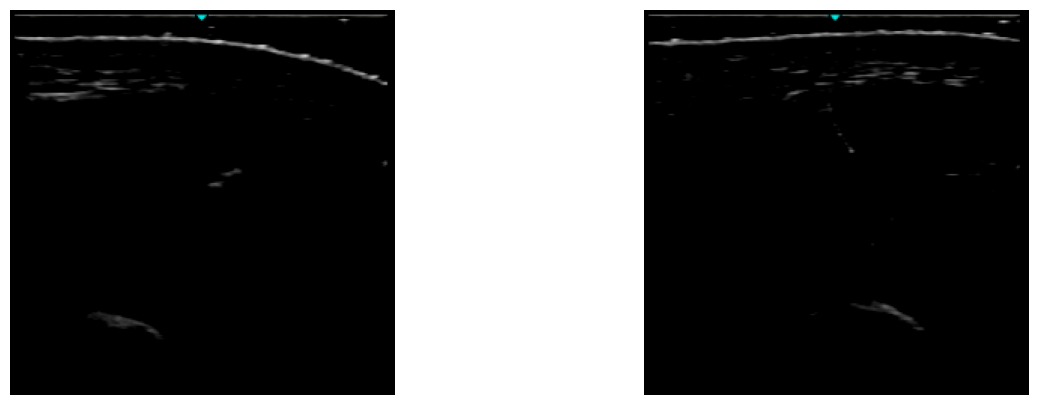

tensor([1.9892], dtype=torch.float64)
tensor([2.1544], dtype=torch.float64)
tensor([47.5000], dtype=torch.float64)


In [ ]:
## Data Augmentation and Transformations
tx_X = transforms.Compose([transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(normalization_factors, normalization_factors)])

REGION = "Q" # Options: B, A, Q, BA, BQ, AQ, BAQ
OUTPUT = "FFM" # Output type: FM, FFM
AUGMENT = 0 # Data augmentation: 0, 5, 8, or 15
SPECKLE = False # Whether to apply median filtering (speckle noise reduction)
dataset = PatientDataset(transform = tx_X,
                 augmented_dataset = False,
                 augment = 0,
                 threshold = False,
                 speckle = SPECKLE,
                 despeckle = False,
                 region_combination = REGION,
                 number_of_image = 2, # Use 1, 2, or 3 images per region
                 crop = [1, 1, 1], # Percentage cropping per region (Abdomen, Biceps, Quadriceps)
                 output = OUTPUT)

## Only if we are augmenting the entire dataset rather than individual image
# augmented_dataset = AugmentedPatientDataset(dataset, transform = tx_X)
# train_size = int(0.8 * len(augmented_dataset))
# test_size = len(augmented_dataset) - train_size
# train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size])

## Dataset Splitting
train_size = int(0.9 * len(dataset))  # 90% for training
test_size = len(dataset) - train_size  # Remaining 10% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
## Data Loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
print(len(train_loader))
print(len(test_loader))# Show if we load the image successfully
## Visualizing the First Batch
for i in range(1):
  first_batch = next(iter(train_loader))
  first_batch_images = first_batch[0]
  first_batch_label = first_batch[1]
  first_batch_W = first_batch[2]
  first_batch_L = first_batch[3]
  fig, axs = plt.subplots(1, len(first_batch_images), figsize=(15, 5))
  for i in range(len(first_batch_images)):
      img = im_converterX(first_batch_images[i][0])
      axs[i].imshow(img)
      axs[i].axis('off')
  plt.show()
  print(first_batch_label)
  print(first_batch_W)
  print(first_batch_L)

## UNet model

The following section defines the **UNet architecture**, a popular convolutional neural network widely used for image segmentation and medical imaging tasks.

Our implementation extends the standard UNet by including dropout layers and fully connected layers for regression outputs.


In [ ]:
class double_conv(nn.Module):
  '''performs two convolution with batch normalization and LeakyReLU activation'''
  '''(conv => BN => ReLU) * 2'''
  def __init__(self, in_ch, out_ch):
    super(double_conv, self).__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_ch, out_ch, 3, padding=1),
      nn.BatchNorm2d(out_ch),
      #nn.Dropout2d(0.7),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Conv2d(out_ch, out_ch, 3, padding=1),
      nn.BatchNorm2d(out_ch),
      #nn.Dropout2d(0.77),
      nn.LeakyReLU(0.1, inplace=True),
    )

  def forward(self, x):
    x = self.conv(x)
    return x

class inconv(nn.Module):
  '''input convolution block to raw images'''
  def __init__(self, in_ch, out_ch):
    super(inconv, self).__init__()
    self.conv = double_conv(in_ch, out_ch)

  def forward(self, x):
    x = self.conv(x)
    return x

class down(nn.Module):
  '''downsampling with maxpooling and double_conv'''
  def __init__(self, in_ch, out_ch):
    super(down, self).__init__()
    self.mpconv = nn.Sequential(
        nn.MaxPool2d(2), # reduces spatial dimensions
        double_conv(in_ch, out_ch)
    )

  def forward(self, x):
    x = self.mpconv(x)
    return x


class up(nn.Module):
  '''upsampling and skip connections'''
  def __init__(self, in_ch, out_ch, bilinear=False):
    super(up, self).__init__()
    if bilinear: # Upsampling will not be learnable
      self.up = nn.Upsample(
        scale_factor=2, mode='bilinear', align_corners=True)
    else:  # it will be learnable here
      self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
    self.conv = double_conv(in_ch, out_ch)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diff1 = x2.shape[2]-x1.shape[2]
    diff2 = x2.shape[3]-x1.shape[3]
    x1 = F.pad(x1, pad=(diff1//2, diff1-diff1//2, diff2//2, diff2-diff2//2))
    x = torch.cat([x2, x1], dim=1)
    x = self.conv(x)
    return x


class outconv(nn.Module):
  '''final output convolution'''
  def __init__(self, in_ch, out_ch):
    super(outconv, self).__init__()
    self.conv = nn.Conv2d(in_ch, out_ch, 1)

  def forward(self, x):
    x = self.conv(x)
    return x

class UNet(nn.Module):
  ''' the Unet class and architecture'''
  def __init__(self, n_channels, n_classes):
    super(UNet, self).__init__()
    '''Encoder path, contracting'''
    self.inc = inconv(n_channels, 64)
    self.down1 = down(64, 128)
    self.down2 = down(128, 256)
    self.down3 = down(256, 512)
    self.down4 = down(512, 512)
    '''Decoder path, expanding'''
    self.up1 = up(1024, 256, bilinear = True) # upsampling weights are made learnable
    self.up2 = up(512, 128, bilinear = True)
    self.up3 = up(256, 64, bilinear = True)
    self.up4 = up(128, 64, bilinear = True)
    '''output and regression layers'''
    self.outc = outconv(64, n_classes)
    self.dropout = torch.nn.Dropout2d(0.1)
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(256*256, 1)
    self.linear2 = nn.Linear(2* 1, 1) # 2 for 1 body part, 4 for 2 body parts, 6 for 3 body parts
    self.linear3 = nn.Linear(3* 1, 1) # 2*3+2+1 for 3 body parts, 2*2+2 for 2 body parts, 2*1+1 for 1 body part
    self.apply(self._init_weights)

  def forward(self, x, weight = None, length = None):
    '''forward pass of the Unet model above'''
    outputs = []
    for image in x:
      x = image.float()
      #print("Input shape before inc:", x.shape)
      x1 = self.inc(x)
      #print("Input shape before down1:", x1.shape)
      x2 = self.down1(x1)
      x2 = self.dropout(x2)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      x5 = self.down4(x4)
      x = self.up1(x5, x4)
      x = self.up2(x, x3)
      x = self.dropout(x)
      x = self.up3(x, x2)
      x = self.dropout(x)
      x = self.up4(x, x1)
      x = self.outc(x)
      x = torch.sigmoid(x)
      x = self.flatten(x)
      x = self.linear1(x)
      outputs.append(x)
    # ## For weight and length
    # # outputs.append(weight)
    # # outputs.append(length)
    # outputs = torch.tensor(outputs).to('cuda')
    # outputs = self.linear2(outputs)
    outputs = torch.tensor(outputs).to('cuda')
    #print(f'output shape before linear 2: {outputs.shape}')
    try:
      outputs = self.linear2(outputs)
    except:
      outputs = self.linear3(outputs)
    return outputs
  def _init_weights(self, module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        nn.init.uniform_(module.weight, a=0.0, b=1.0)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0.1)


In [ ]:
## Instantiated the model and sending to GPU
MODEL = "UNet"
model = UNet(3, 1).cuda()



## Model Training- (Random Allocation & K-Folds Cross Validation)

This section deals with training the UNet model. In particular, both random allocation and k-folds cross validation is implemented. Ultimately, k-folds achieved more robust results.

The training calls the training function defined 2 sections ago. The validation and training history is tracked for both.

### Random Allocation

In [ ]:
CRITERION = "MSE" # Loss function ("MSE", "MAE", "MAPE", or "Custom")
WL = False # Include weight + length metadata (True/False)
EPOCHS = 100 # Number of training epochs (60-100)
LR = 0.001 # Learning rate (0.001 for UNet)
ADAPTIVE = True # Use adaptive learning rate scheduling
train_history, validation_history = training(EPOCHS, CRITERION, LR, model, MODEL, ADAPTIVE, WL) # Model Training

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
## Plotting and Visualization of Training and Validation Losses for Random Allocation
plt.plot(train_history, label = 'Train Loss')
plt.plot(validation_history, label = 'Validation Loss')
plt.legend()

#### Saving and Loading the Model

This section handles saving a trained model to Google Drive and reloading it later for evaluation or inference.


In [ ]:
model_folder = '/content/gdrive/MyDrive/Ultrasound Files- Minnesota + Boston Collaboration/saved_models/'
number_of_images = '3'
date = '2025-07-09'
# Construct model filename with training configuration
name = os.path.join(model_folder, MODEL+"_"+CRITERION+"_"+str(LR)+"_Adaptive-"+str(ADAPTIVE)+"_"+str(AUGMENT)+"x_"+REGION+"_"+OUTPUT+"_"+str(100)+"epochs_WL-"+str(WL)+"_"+str(date)+".pt")
print(name)
# Save model
torch.save(model, name)

In [ ]:
# Loading the Model

# Define configuration for loading
LOAD_MODEL = "UNet"
LOAD_CRITERION = "MSE" # Other options: "MAE", "MAPE"
LOAD_LR = 0.001
LOAD_ADAPTIVE = True
LOAD_REGION = "B" # "BAQ", "BA", "BQ", "AQ", "B“, "A", "Q"
LOAD_AUGMENT = 0
LOAD_OUTPUT = "FFM" # "FM", "FFM"
LOAD_EPOCHS = 100
LOAD_WL = False
LOAD_date = '2025-07-09' # change date loaded accordingly

# Construct filename for reloading
model_folder = '/content/gdrive/MyDrive/Ultrasound Files- Minnesota + Boston Collaboration/saved_models/'
model_name = os.path.join(model_folder, LOAD_MODEL+"_"+LOAD_CRITERION+"_"+str(LOAD_LR)+"_Adaptive-"+str(LOAD_ADAPTIVE)+"_"+str(LOAD_AUGMENT)+"x_"+LOAD_REGION+"_"+LOAD_OUTPUT+"_"+str(LOAD_EPOCHS)+"epochs_WL-"+str(LOAD_WL)+"_"+LOAD_date+".pt")
print(model_name)

# Reload model
model = torch.load(model_name, weights_only=False)
model.to('cuda')
model.eval()

###K-Folds Validation

Here, we use k-folds validation for classification data. K-holds trains the data in 5 "folds" or batches. The data is split into these 5 equal sized folds (k = 5 here, but can be split further) The model is then trained on k-1 folds and tested on the remaining fold. The process is repeated with each fold acting as the test. Model performance statistics can then be generated from these results.

In [ ]:
# Importing necessary cross validation packages
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import KFold

The following function initializes a function which performs k-folds cross validation on the dataset,
training a new model for each fold and averaging the results.

In [ ]:
def kfolds_cross_validation(dataset, model_builder, criterion, epochs, lr, n_splits=5, adaptive=True, weight_length=False,
                            MODEL="UNet", region="BAQ", output="FM", number_of_image=2, crop=[1,1,1], augment=0,
                            threshold=False, speckle=False, despeckle=False):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)# declaration of the kfolds cross validation method to split dataset

    all_train_loss_histories = []#initialize lists of losses
    all_validation_loss_histories = []

    # Get the list of patient indices from the original dataset
    dataset_indices = list(range(len(dataset)))

    for fold, (train_index, val_index) in enumerate(kf.split(dataset_indices)):
        print(f"==================== Fold {fold+1}/{n_splits} ====================")# this print statement keeps
        #track of the fold in which the data is being tested on while the model runs- same formatting as the model training script

        # Create train and validation datasets for the current fold using subset
        train_subset = torch.utils.data.Subset(dataset, train_index)
        val_subset = torch.utils.data.Subset(dataset, val_index)


        # Create DataLoaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        test_loader = DataLoader(val_subset, batch_size=1, shuffle=False) # Use test_loader name for consistency with training function

        # Initialize a new model for each fold!!
        model = model_builder().to('cuda')

        # Train the model for the current fold
        train_history, val_history = training(
            epochs=epochs,
            criterion=criterion,
            lr=lr,
            model=model,
            MODEL=MODEL,
            adaptive=adaptive,
            weight_length=weight_length
        )

        all_train_loss_histories.append(train_history)
        all_validation_loss_histories.append(val_history)

    # Calculate average loss histories across all folds
    avg_train_loss_history = np.mean(all_train_loss_histories, axis=0).tolist()
    avg_validation_loss_history = np.mean(all_validation_loss_histories, axis=0).tolist()

    #the k-folds function returns a dictionary containing the average train and validation loss histories
              #across all folds, and lists of individual fold histories
    return {
        'avg_train_loss_history': avg_train_loss_history,
        'avg_validation_loss_history': avg_validation_loss_history,
        'train_loss_histories_per_fold': all_train_loss_histories,
        'validation_loss_histories_per_fold': all_validation_loss_histories
    }

This cell is a model builder & dataset setup for K-Folds


In [ ]:

def build_unet_model():
  '''Define the model building function which initializes and calls for the UNet model to run.
This ensures a *new* model is created for each fold during cross-validation.'''
    return UNet(3, 1) # Input channels = 3, Output channels = 1

# Define your dataset parameters
REGION = "Q" #B, A, Q, BA,BQ, AQ, BAQ
OUTPUT = "FFM" # FM, FFM
AUGMENT = 0 # 0, 5, 8, 15
SPECKLE = False # Medianfilter Off
THRESHOLD = False # No thresholding
DESPECKLE = False # No despeckle preprocessing
NUMBER_OF_IMAGE = 2 #1, 2, 3
CROP = [1, 1, 1] #Keep Full Image

# Create the full dataset (without explicit train/test split here)- same in the UNet model function using the PatientDataset function
# The k-folds function will handle the splitting internally
full_dataset = PatientDataset(transform = tx_X,
                             augmented_dataset = False, # k-folds will not use the AugmentedPatientDataset wrapper
                             augment = AUGMENT,
                             threshold = THRESHOLD,
                             speckle = SPECKLE,
                             despeckle = DESPECKLE,
                             region_combination = REGION,
                             number_of_image = NUMBER_OF_IMAGE,
                             crop = CROP,
                             output = OUTPUT)



The following cell performs the k-folds validation on the dataset

In [ ]:
# Run k-folds cross-validation
kf_results = kfolds_cross_validation(
     dataset=full_dataset,
     model_builder=build_unet_model, # UNet
     criterion='MSE',
     epochs=8, # Set the number of epochs per fold
     lr=0.001,#LR = 0.001 for UNet
     n_splits=5, # we want to run 5 folds = k
     adaptive=True,
     weight_length=False, # Set to True if your model uses weight and length
     MODEL='UNet', # Set to your model name
     region=REGION, # make sure this is consistent with the regions specified above
     output=OUTPUT,
     number_of_image=NUMBER_OF_IMAGE,
     crop=CROP,
     augment=AUGMENT,
     threshold=THRESHOLD,
     speckle=SPECKLE,
     despeckle=DESPECKLE
 )


==================== Fold 1/5 ====================
Epoch:  1 Batch:  0 Current Loss:  3.472325325012207
Epoch:  1 Batch:  5 Current Loss:  1.9788787364959717
Epoch:  1 Batch:  10 Current Loss:  4.092232704162598
Epoch:  1 Batch:  15 Current Loss:  2.6928670406341553
Epoch:  1 Batch:  20 Current Loss:  1.1964585781097412
Epoch:  1 Batch:  25 Current Loss:  5.67573356628418
Epoch:  1 Batch:  30 Current Loss:  3.2126331329345703
Epoch:  1 Batch:  35 Current Loss:  3.3967111110687256
Epoch:  1 Batch:  40 Current Loss:  3.5237746238708496
Epoch:  1 Batch:  45 Current Loss:  3.8035411834716797
Epoch:  1 Batch:  50 Current Loss:  2.3389267921447754
Epoch 1 completed
Average train loss is 3.3053049192978787: 
Average validation loss is 3.3664359052975974
Epoch:  2 Batch:  0 Current Loss:  3.2248024940490723
Epoch:  2 Batch:  5 Current Loss:  2.5599570274353027
Epoch:  2 Batch:  10 Current Loss:  2.910195827484131
Epoch:  2 Batch:  15 Current Loss:  5.40998649597168
Epoch:  2 Batch:  20 Current

The validation and training losses can be seen and tracked like below.

In [ ]:
#Average results of the cross validation by accessing the keys in the dictionary containing these metrics
# Print average results
print("Average Training Loss History:", kf_results['avg_train_loss_history'])
print("Average Validation Loss History:", kf_results['avg_validation_loss_history'])

# You can also access individual fold histories:
print("Individual Fold Training Loss Histories:", kf_results['train_loss_histories_per_fold'])
print("Individual Fold Validation Loss Histories:", kf_results['validation_loss_histories_per_fold'])

Average Training Loss History: [4.895175474423629, 4.474085745215416, 4.0537945444767285, 3.6711539197426575, 3.333289599877138, 3.0343698030480972, 2.7706239456167587, 2.5458934129430695]
Average Validation Loss History: [4.840406588713328, 4.370461940765381, 3.9692393819491065, 3.612688740094503, 3.292643757661184, 3.034378635883331, 2.7947027484575906, 2.570181214809418]
Individual Fold Training Loss Histories: [[3.3053049192978787, 3.041634356746307, 2.7633780447336345, 2.5241021708800244, 2.290134601868116, 2.0859824023567715, 1.8985437871171877, 1.7416280307448828], [6.140196103316087, 5.522631012476408, 4.878240754971137, 4.308259033239805, 3.836235768519915, 3.4288213344720693, 3.0840854965723477, 2.7823646309284062], [4.577015111079583, 4.1853995093932514, 3.8132256957200856, 3.4925328493118286, 3.2098064789405236, 2.9650112894865184, 2.7342299222946167, 2.533419053141887], [6.507584911126357, 6.000206209146059, 5.499525285684145, 5.008753698605758, 4.556112337570924, 4.153659

The losses of each fold can be visualized in graphs below to determine which best fits the model.

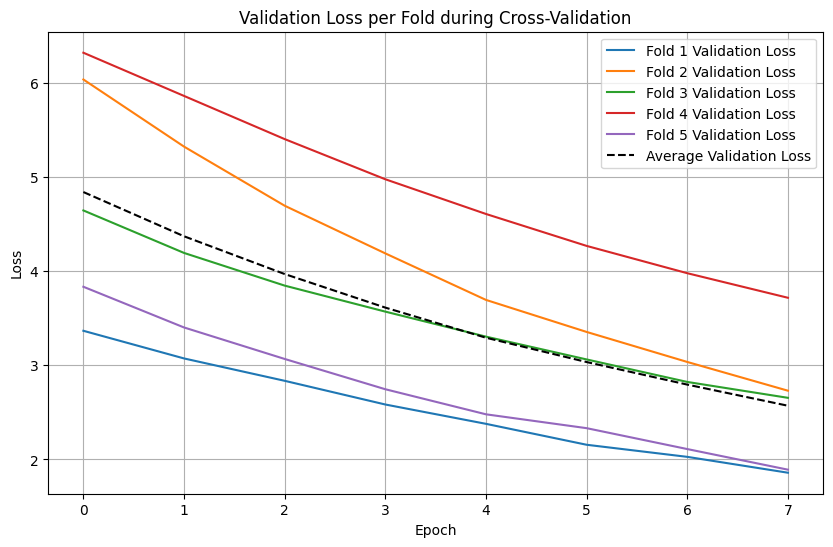

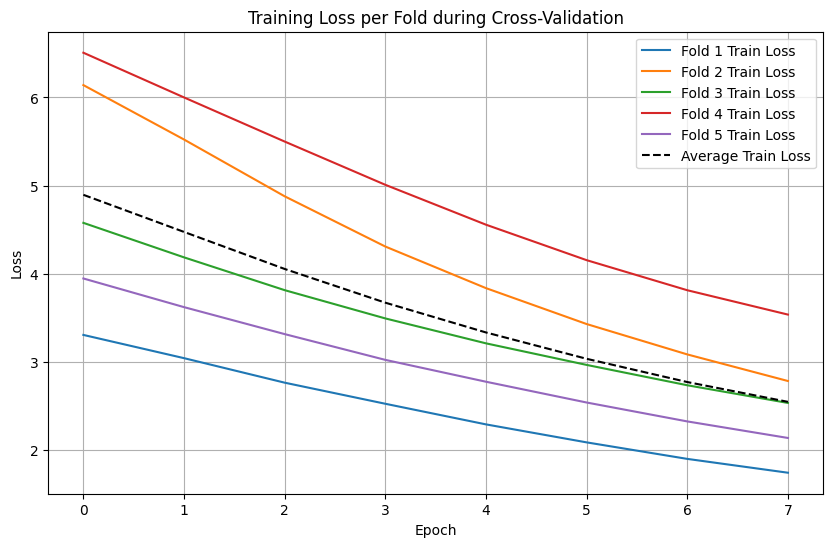

In [ ]:
# visualizing the loss histories for each fold using plt
plt.figure(figsize=(10, 6))
for i, history in enumerate(kf_results['validation_loss_histories_per_fold']):
    plt.plot(history, label=f'Fold {i+1} Validation Loss')
plt.plot(kf_results['avg_validation_loss_history'], label='Average Validation Loss', linestyle='--', color='black')
plt.title('Validation Loss per Fold during Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for i, history in enumerate(kf_results['train_loss_histories_per_fold']):
    plt.plot(history, label=f'Fold {i+1} Train Loss')
plt.plot(kf_results['avg_train_loss_history'], label='Average Train Loss', linestyle='--', color='black')
plt.title('Training Loss per Fold during Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### K-Folds cross validation (on Median Fold)

The following cells perform the same k-folds cross validation except use the median fold to then retrain the entire data on the full number of epochs. The same k-folds algorithm used above is used here.

The following two functions define the behavior and the k-folds algorithm on our dataset.

In [ ]:
def evaluate_median_fold_predictions(dataset, model_builder, criterion, epochs, lr, n_splits=5, adaptive=True, weight_length=False,
                                     MODEL="UNet", region="BAQ", output="FM", number_of_image=3, crop=[1,1,1], augment=0,
                                     threshold=False, speckle=False, despeckle=False):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_validation_loss_histories = []
    folds_data = [] # To store the indices for each fold

    # Get the list of patient indices from the original dataset
    dataset_indices = list(range(len(dataset)))

    for fold, (train_index, val_index) in enumerate(kf.split(dataset_indices)):
        print(f"==================== Fold {fold+1}/{n_splits} ====================")

        train_subset = torch.utils.data.Subset(dataset, train_index)
        val_subset = torch.utils.data.Subset(dataset, val_index)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False) # Use val_loader for validation

        folds_data.append({'train_indices': train_index, 'val_indices': val_index, 'val_loader': val_loader})

        model = model_builder().to('cuda')

        _, val_history = training(
            epochs=8,
            criterion=criterion,
            lr=lr,
            model=model,
            MODEL=MODEL,
            adaptive=adaptive,
            weight_length=weight_length
        )

        all_validation_loss_histories.append(val_history[-1]) # Store final validation loss for the fold

    # Find the fold with the median validation loss
    median_loss = np.median(all_validation_loss_histories)
    median_fold_index = np.argmin(np.abs(np.array(all_validation_loss_histories) - median_loss))
    print(f"\nMedian validation loss ({median_loss:.4f}) occurred in Fold {median_fold_index + 1}")

    # Get the validation data for the median fold
    median_fold_val_loader = folds_data[median_fold_index]['val_loader']
    median_fold_val_indices = folds_data[median_fold_index]['val_indices']
    print(f"Using validation data from Fold {median_fold_index + 1} as the test data.")

    # Retrain the model on the training data of the median fold
    print(f"Retraining model on training data from Fold {median_fold_index + 1}")
    train_subset_median_fold = torch.utils.data.Subset(dataset, folds_data[median_fold_index]['train_indices'])
    train_loader_median_fold = DataLoader(train_subset_median_fold, batch_size=1, shuffle=True)

    median_model = model_builder().to('cuda')
    training(
        epochs=90,
        criterion=criterion,
        lr=lr,
        model=median_model,
        MODEL=MODEL,
        adaptive=adaptive,
        weight_length=weight_length
    )
    return median_model

In [ ]:
def train_model_on_median_fold(dataset, model_builder, criterion, lr, n_splits=5,
                               adaptive=True, weight_length=False, MODEL="UNet"):
    from sklearn.model_selection import KFold
    import numpy as np
    import torch
    from torch.utils.data import DataLoader

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_losses = []
    folds_data = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(dataset)))):
        print(f"\nFOLD {fold + 1}/{n_splits}")
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)

        model = model_builder().to('cuda')
        _, val_history = training(
            epochs=8,
            criterion=criterion,
            lr=lr,
            model=model,
            MODEL=MODEL,
            adaptive=adaptive,
            weight_length=weight_length
        )

        val_losses.append(val_history[-1])
        folds_data.append({
            'train_indices': train_idx,
            'val_loader': val_loader
        })

    # Identify median fold
    median_loss = np.median(val_losses)
    median_fold_index = np.argmin(np.abs(np.array(val_losses) - median_loss))
    print(f"\n▶ Median validation loss: {median_loss:.4f} (Fold {median_fold_index + 1})")

    # Retrain on median fold
    train_idx = folds_data[median_fold_index]['train_indices']
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)

    model = model_builder().to('cuda')
    print(f"\n▶ Retraining on Fold {median_fold_index + 1} for 90 epochs...")
    training(
        epochs=90,
        criterion=criterion,
        lr=lr,
        model=model,
        MODEL=MODEL,
        adaptive=adaptive,
        weight_length=weight_length
    )

    return model  # <-- return the trained model


The cell below implements the training on the median fold by loading the data using the PatientDataset function previously defined.



In [ ]:
# First: Train on median fold
full_dataset = PatientDataset(transform = tx_X,
                             augmented_dataset = False,
                             augment = 0,
                             threshold = THRESHOLD,
                             speckle = SPECKLE,
                             despeckle = DESPECKLE,
                             region_combination = REGION,
                             number_of_image = 2,
                             crop = CROP,
                             output = OUTPUT)

trained_model = train_model_on_median_fold(
    dataset=full_dataset,  # Your full dataset
    model_builder=build_unet_model,
    criterion="MSE",
    lr=0.001,
    n_splits=5,
    adaptive=True,
    weight_length=False,  # or True if using weight/length
    MODEL="UNet"
)

# Then: Evaluate that model on your test dataset
# (Paste the inference/evaluation code from earlier, replacing `model = model.to('cuda')` with `trained_model`


FOLD 1/5
Epoch:  1 Batch:  0 Current Loss:  2.6797101497650146
Epoch:  1 Batch:  5 Current Loss:  3.100498914718628
Epoch:  1 Batch:  10 Current Loss:  4.512420654296875
Epoch:  1 Batch:  15 Current Loss:  2.71207594871521
Epoch:  1 Batch:  20 Current Loss:  3.416060447692871
Epoch:  1 Batch:  25 Current Loss:  3.8137052059173584
Epoch:  1 Batch:  30 Current Loss:  2.780428647994995
Epoch:  1 Batch:  35 Current Loss:  3.77006459236145
Epoch:  1 Batch:  40 Current Loss:  2.383972644805908
Epoch:  1 Batch:  45 Current Loss:  3.7556986808776855
Epoch:  1 Batch:  50 Current Loss:  2.7021491527557373
Epoch 1 completed
Average train loss is 3.804071822991738: 
Average validation loss is 3.7246625423431396
Epoch:  2 Batch:  0 Current Loss:  3.623713254928589
Epoch:  2 Batch:  5 Current Loss:  3.0318703651428223
Epoch:  2 Batch:  10 Current Loss:  2.7382211685180664
Epoch:  2 Batch:  15 Current Loss:  4.278990268707275
Epoch:  2 Batch:  20 Current Loss:  2.25752854347229
Epoch:  2 Batch:  25 

###Testing the Model Performance



The cell below loads the test data that was first identified as 10% of the entire dataset. Predictions are made based on the predictions made from the cross-validation model. There should be a total of 7 predictions.

In [ ]:
#loading test data, making predictions with cross-validation model
trained_model = trained_model.to('cuda')
model = trained_model
model.eval()

normalization_factors = 0.5
tx_X = transforms.Compose([transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(normalization_factors, normalization_factors)])
REGION = "Q"
OUTPUT = "FFM"
test_dataset = TestPatientDataset(transform = tx_X,
                 augmented_dataset = False,
                 augment = 0,
                 threshold = False,
                 speckle = True,
                 despeckle = False,
                 region_combination = REGION,
                 number_of_image = 2,
                 crop = [1, 1, 1],
                 output = OUTPUT)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(len(test_loader))
#test_model_on_dataset(trained_model, test_loader, MODEL="UNet", weight_length=False)

7


The code below does NOT apply a sigmoid normalization to the prediction values and to the true values.

In [ ]:
##RUN ONLY THIS ONE FOR NO SIGMOID FUNCTION
true_labels = []
prediction = []
WL = False
for ith_batch, batch in enumerate(test_loader):
  X_train = [image.to('cuda') for image in batch[0]]
  y_train = batch[1].to('cuda').float()[0]
  if WL:
    if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
      additional_data_train = torch.tensor([[batch[2].item(), batch[3].item()]]).to('cuda').float()
      y_pred = model(X_train, additional_data_train)
    if MODEL == "UNet":
      weight = batch[2].to('cuda').float()[0]
      length = batch[3].to('cuda').float()[0]
      y_pred = model(X_train, weight, length)
  else:
    y_pred = model(X_train) #get rid of [0] for EffNet
    print(y_pred)
  true_labels.append(y_train)
  prediction.append(y_pred)

tensor([1.3712], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.3925], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.4688], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.5094], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.1618], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.4151], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1.2835], device='cuda:0', grad_fn=<ViewBackward0>)


In the cell below, a sigmoid normalization function defined by "nn.Sigmoid" is applied to the outputs

In [ ]:
##RUN ONLY THIS ONE FOR SIGMOID FUNCTION
true_labels = []
prediction = []
WL = False
sigmoid = nn.Sigmoid() # Define the sigmoid function

for ith_batch, batch in enumerate(test_loader):
  X_train = [image.to('cuda') for image in batch[0]]
  y_train = batch[1].to('cuda').float()[0] # This is the ground truth value

  # Apply sigmoid normalization to the ground truth
  y_train_normalized = sigmoid(y_train)

  if WL:
    if MODEL == "EffNet_LP" or MODEL == "EffNet_FT":
      additional_data_train = torch.tensor([[batch[2].item(), batch[3].item()]]).to('cuda').float()
      y_pred = model(X_train, additional_data_train)
    if MODEL == "UNet":
      weight = batch[2].to('cuda').float()[0]
      length = batch[3].to('cuda').float()[0]
      y_pred = model(X_train, weight, length)
  else:
    y_pred = model(X_train) #get rid of [0] for EffNet
    y_pred = sigmoid(y_pred) # Apply sigmoid to the predicted output
    print(y_pred) # Print the sigmoid-normalized prediction

  true_labels.append(y_train_normalized) # Append the sigmoid-normalized ground truth
  prediction.append(y_pred)


tensor([0.5789], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.5498], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.5546], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.5615], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.5981], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.5415], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.5769], device='cuda:0', grad_fn=<SigmoidBackward0>)


The code below iterates through the prediction and true_label tensors and extracts the ground truth and prediction values for the corresponding body composition indicated.

In [ ]:

GT_FM = []
Pred_FM = []
for i in range(len(true_labels)):
  gt = torch.Tensor.tolist(true_labels[i])
  GT_FM.append(gt)
  pred = torch.Tensor.tolist(prediction[i])
  Pred_FM.append(pred)
print(GT_FM)
print(Pred_FM)

[1.9401999711990356, 2.177799940109253, 1.330899953842163, 2.4855000972747803, 2.0833001136779785, 2.3958001136779785, 2.1493000984191895]
[[1.3711689710617065], [1.392545223236084], [1.4688116312026978], [1.5094141960144043], [1.1617728471755981], [1.4151356220245361], [1.2835265398025513]]


This cell generates statistical values, specifically MAE, MSE, RMSE and MAPE by calling the functions defined in 3 sections above.

In [ ]:


y_true = torch.tensor(GT_FM)
y_pred = torch.tensor(Pred_FM)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAE:", mae.item())
print("MSE:", mse.item())
print("RMSE:", rmse)
print("MAPE:", mape.item())

MAE: 0.7291454672813416
MSE: 0.6367015242576599
RMSE: 0.7979357895580695
MAPE: 33.12993240356445


The cell below are stored values of the predictioins for all body parts and for both fat-mass and fat-free mass.

In [ ]:
#stored values for the FM and FFM Cross Validation

#B
B_GT_FM = [0.18799999356269836, 0.11249999701976776, 0.15880000591278076, 0.1216999962925911, 0.22089999914169312, 0.2667999863624573, 0.1712999939918518]
B_Pred_FM = [0.20500195026397705, 0.20162492990493774, 0.14781782031059265, 0.19136351346969604, 0.2455073893070221, 0.15497896075248718, 0.20594215393066406]
B_GT_FFM = [1.9401999711990356, 2.177799940109253, 1.330899953842163, 2.4855000972747803, 2.0833001136779785, 2.3958001136779785, 2.1493000984191895]
B_Pred_FFM = [2.757734775543213, 2.2144815921783447, 2.1421613693237305, 2.2592835426330566, 1.518340826034546, 2.3250253200531006, 1.9929399490356445]
#A
A_GT_FM = [0.18799999356269836, 0.11249999701976776, 0.15880000591278076, 0.1216999962925911, 0.22089999914169312, 0.2667999863624573, 0.1712999939918518]
A_Pred_FM = [0.209541454911232, 0.21115493774414062, 0.12128032743930817, 0.2225373387336731, 0.16770170629024506, 0.16742369532585144, 0.1346481591463089]
A_GT_FFM = [1.9401999711990356, 2.177799940109253, 1.330899953842163, 2.4855000972747803, 2.0833001136779785, 2.3958001136779785, 2.1493000984191895]
A_Pred_FFM = [2.048482894897461, 1.9155126810073853, 1.9990923404693604, 2.0141658782958984, 1.9924914836883545, 2.2583343982696533, 2.0133557319641113]
#Q
Q_GT_FM = [0.18799999356269836, 0.11249999701976776, 0.15880000591278076, 0.1216999962925911, 0.22089999914169312, 0.2667999863624573, 0.1712999939918518]
Q_Pred_FM = [0.24577286839485168, 0.18429425358772278, 0.13029831647872925, 0.26359987258911133, 0.25254562497138977, 0.22110436856746674, 0.22817453742027283]
Q_GT_FFM = [1.9401999711990356, 2.177799940109253, 1.330899953842163, 2.4855000972747803, 2.0833001136779785, 2.3958001136779785, 2.1493000984191895]
Q_Pred_FFM = [1.9358863830566406, 2.2595109939575195, 1.7210971117019653, 1.8491266965866089, 1.8327335119247437, 2.37453556060791, 1.900198221206665]

#AB
AB_GT_FM = [0.18799999356269836, 0.11249999701976776, 0.15880000591278076, 0.1216999962925911, 0.22089999914169312, 0.2667999863624573, 0.1712999939918518]
AB_Pred_FM = [0.1442546397447586, 0.13715466856956482, 0.12666714191436768, 0.09703982621431351, 0.08471442013978958, 0.12380579113960266, 0.1723576784133911]
AB_GT_FFM = [1.9401999711990356, 2.177799940109253, 1.330899953842163, 2.4855000972747803, 2.0833001136779785, 2.3958001136779785, 2.1493000984191895]
AB_Pred_FFM = [2.0020031929016113, 1.7727031707763672, 2.2810564041137695, 1.6321742534637451, 2.2304441928863525, 1.5702838897705078, 1.9314885139465332]
#BQ
BQ_GT_FM = [0.18799999356269836, 0.11249999701976776, 0.15880000591278076, 0.1216999962925911, 0.22089999914169312, 0.2667999863624573, 0.1712999939918518]
BQ_Pred_FM = [0.04911166429519653, 0.21013033390045166, 0.1536998748779297, 0.24271684885025024, 0.08311238884925842, 0.10670161247253418, 0.17423388361930847]
BQ_GT_FFM = [1.9401999711990356, 2.177799940109253, 1.330899953842163, 2.4855000972747803, 2.0833001136779785, 2.3958001136779785, 2.1493000984191895]
BQ_Pred_FFM = [1.5943398475646973, 1.3063938617706299, 1.6029713153839111, 2.224280834197998, 2.596879005432129, 1.890488862991333, 1.6798439025878906]
#AQ
AQ_GT_FM = [0.18799999356269836, 0.11249999701976776, 0.15880000591278076, 0.1216999962925911, 0.22089999914169312, 0.2667999863624573, 0.1712999939918518]
AQ_Pred_FM = [0.1191667914390564, 0.1515413075685501, 0.14122124016284943, 0.14102932810783386, 0.22502635419368744, 0.11825451999902725, 0.11749393492937088]
AQ_GT_FFM = [1.9401999711990356, 2.177799940109253, 1.330899953842163, 2.4855000972747803, 2.0833001136779785, 2.3958001136779785, 2.1493000984191895]
AQ_Pred_FFM = [1.983097791671753, 2.2171883583068848, 2.070427894592285, 3.040140151977539, 2.979398488998413, 2.038315773010254, 2.5559520721435547]

#BAQ
BAQ_GT_FM = [0.18799999356269836, 0.11249999701976776, 0.15880000591278076, 0.1216999962925911, 0.22089999914169312, 0.2667999863624573, 0.1712999939918518]
BAQ_Pred_FM = [0.1830354928970337, 0.20761433243751526, 0.1232530027627945, 0.15658175945281982, 0.198316290974617, 0.14617139101028442, 0.20796121656894684]
BAQ_GT_FFM = [1.9401999711990356, 2.177799940109253, 1.330899953842163, 2.4855000972747803, 2.0833001136779785, 2.3958001136779785, 2.1493000984191895]
BAQ_Pred_FFM = [1.7488856315612793, 1.699321985244751, 1.1762871742248535, 1.8969175815582275, 2.3902523517608643, 1.4723296165466309, 1.8761663436889648]